In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Recurrent neural network**

<h1 style="background-color:#1afCCC;font-family:ALGERIAN;font-size:250%;text-align:center;border-radius: 15px 15px;padding: 5px">LIBRARIES USED</h1>


In [ ]:
from wordcloud import WordCloud
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
!pip install neattext
import neattext.functions as nfx
import matplotlib.pyplot as plt
import plotly.express as plx
from sklearn.metrics import classification_report
import keras
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 9.5 MB/s eta 0:00:00


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/suicide/Suicide_Detection.csv')
data.head(10)

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
5,11,Honetly idkI dont know what im even doing here...,suicide
6,12,[Trigger warning] Excuse for self inflicted bu...,suicide
7,13,It ends tonight.I can’t do it anymore. \nI quit.,suicide
8,16,"Everyone wants to be ""edgy"" and it's making me...",non-suicide
9,18,My life is over at 20 years oldHello all. I am...,suicide


In [ ]:
data['class'].value_counts()

suicide        116037
non-suicide    116037
Name: class, dtype: int64

In [ ]:
data['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

<h1 style="background-color:#1afCCC;font-family:ALGERIAN;font-size:250%;text-align:center;border-radius: 15px 15px;padding: 5px">DATA-SET SPLIT</h1>


In [ ]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=10)

<h1 style="background-color:#1afCCC;font-family:ALGERIAN;font-size:250%;text-align:center;border-radius: 15px 15px;padding: 5px">DATA VISUALISATIONS</h1>


In [ ]:
train_data['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

In [ ]:
plt.bar(train_data,x=train_data['class'].value_counts().index.values,
        y=train_data['class'].value_counts(),color=['Suicide','Not Suicide'])
plt.show()

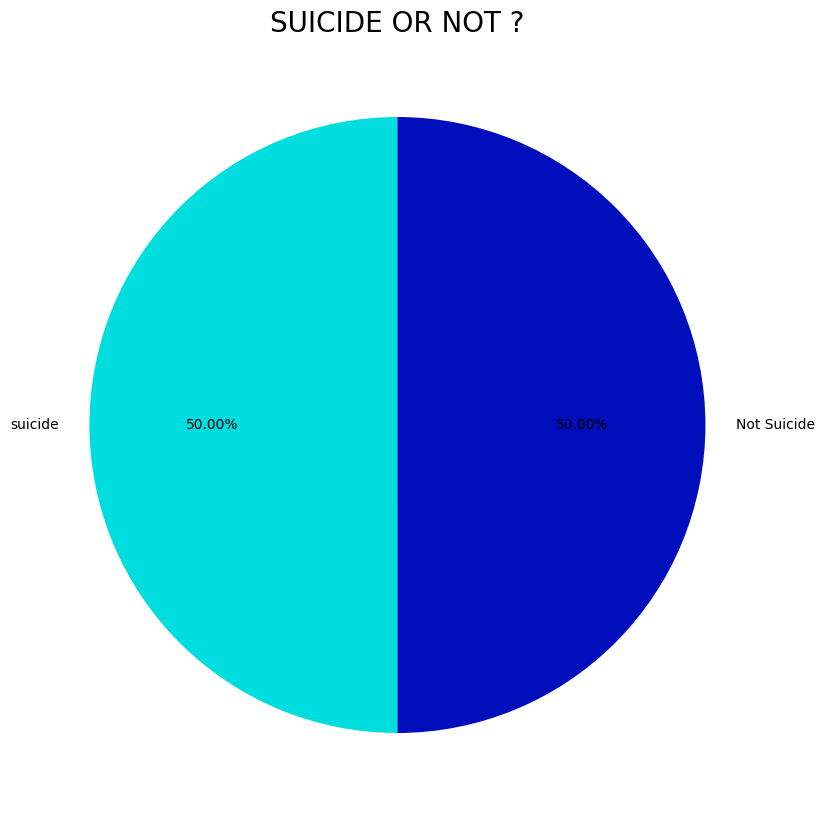

In [ ]:
plt.figure(figsize=(12,10))
plt.pie(train_data['class'].value_counts(),startangle=90,colors=['#00dddf','#000fbb'],
        autopct='%0.2f%%',labels=['suicide','Not Suicide'])
plt.title('SUICIDE OR NOT ?',fontdict={'size':20})
plt.show()

<h1 style="background-color:#1afCCC;font-family:ALGERIAN;font-size:250%;text-align:center;border-radius: 15px 15px;padding: 5px">DATA CLEANING</h1>


In [ ]:

def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for sent in tqdm(text):
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_stopwords(sent)
#         sent=nfx.remove_shortwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text,text_length

In [ ]:
cleaned_train_text,train_text_length=clean_text(train_data.text)
cleaned_test_text,test_text_length=clean_text(test_data.text)



100%|██████████| 46415/46415 [00:02<00:00, 18096.80it/s]


In [ ]:
print(cleaned_test_text)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



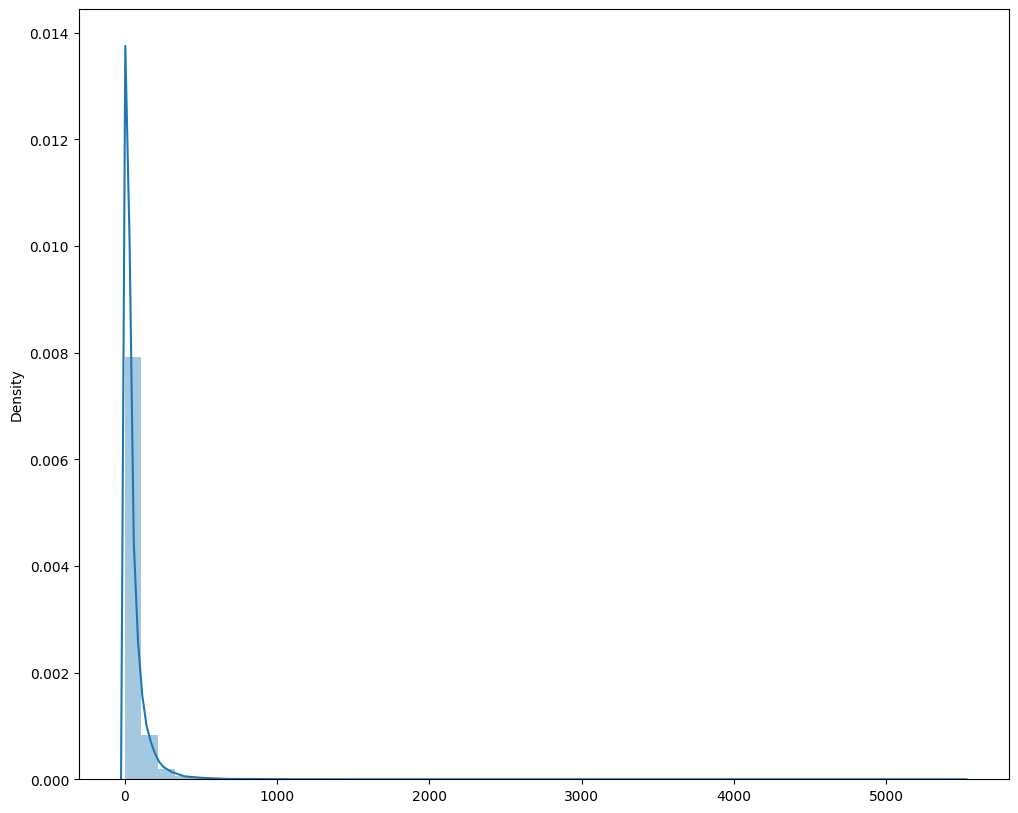

In [ ]:
plt.figure(figsize=(12,10))
sns.distplot(train_text_length)
# plt.axis([-10,100,0,0.03])
plt.show()

In [ ]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

In [ ]:
word_freq=pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)

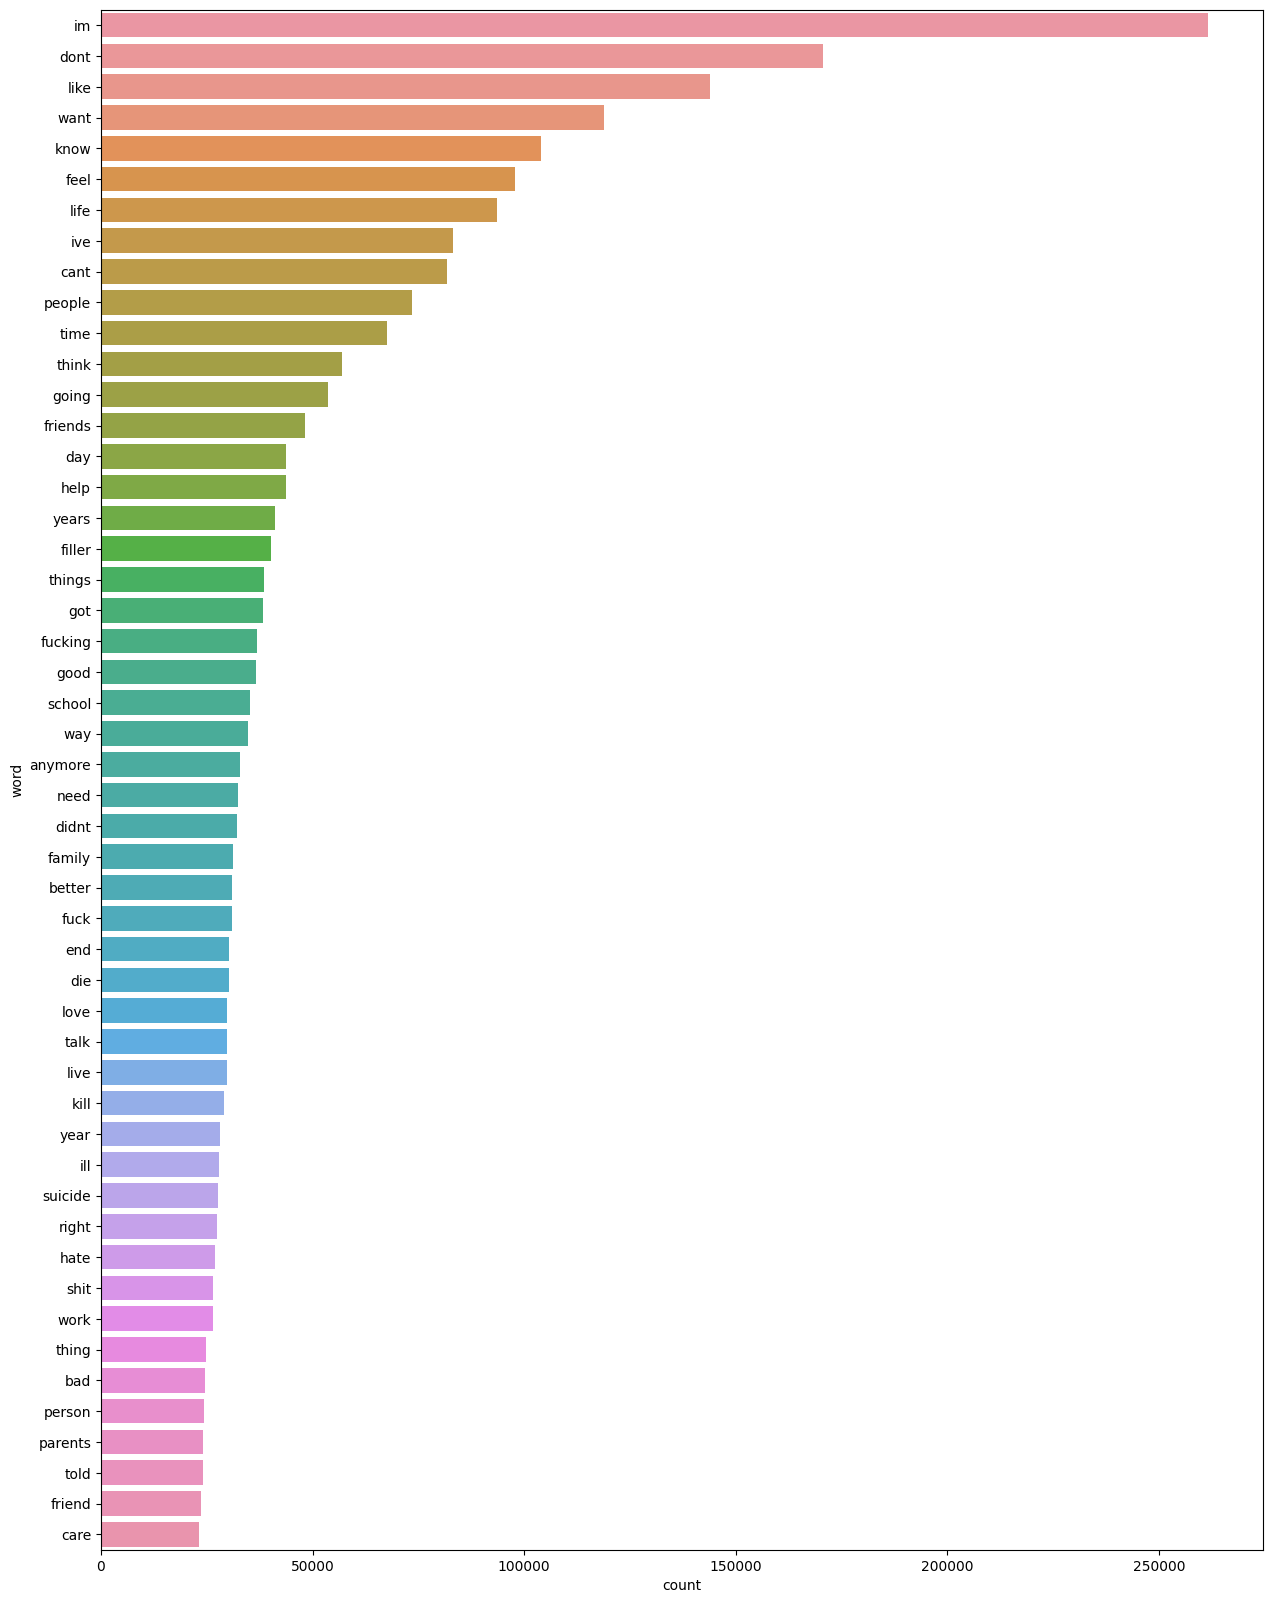

In [ ]:
plt.figure(figsize=(15,20))
sns.barplot(x='count',y='word',data=word_freq.iloc[:50])
plt.show()

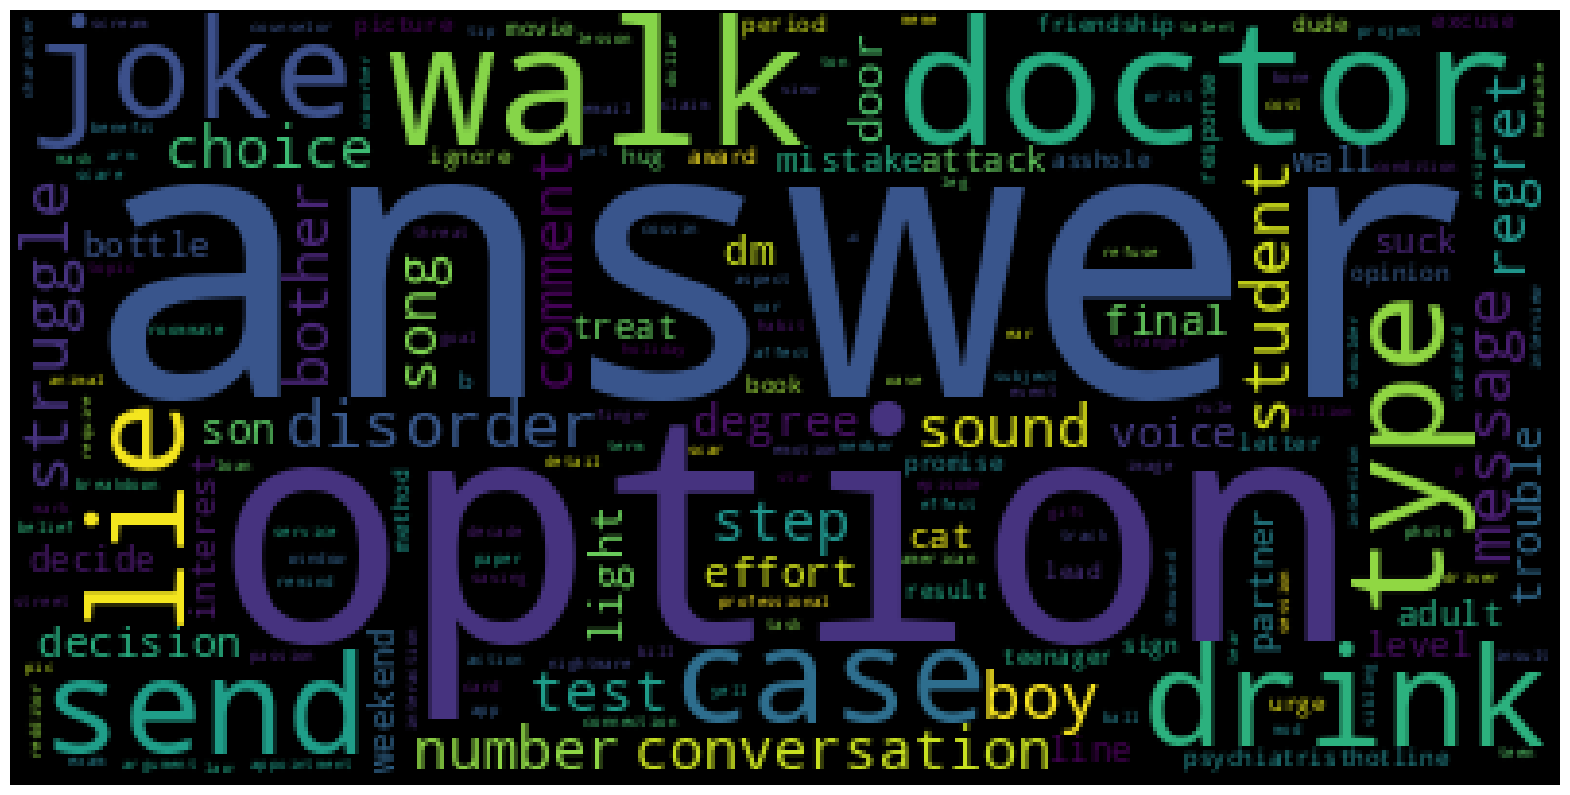

In [ ]:
feature_names=word_freq['word'].values
wc=WordCloud(max_words=400)
wc.generate(' '.join(word for word in feature_names[500:3500] ))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)

<h1 style="background-color:#1afCCC;font-family:ALGERIAN;font-size:250%;text-align:center;border-radius: 15px 15px;padding: 5px">PREPROCESSING TEXT DATA</h1>


In [ ]:
train_text_seq=tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad=pad_sequences(train_text_seq,maxlen=50)


test_text_seq=tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=50)

In [ ]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.transform(test_data['class'])

<h1 style="background-color:#1afCCC;font-family:ALGERIAN;font-size:250%;text-align:center;border-radius: 15px 15px;padding: 5px">GLOVE EMBEDDINGS</h1>


In [ ]:
# glove_embedding={}
with open('/content/drive/MyDrive/Colab Notebooks/suicide/glove.840B.300d.pkl', 'rb') as fp:
    glove_embedding = pickle.load(fp)

In [ ]:
v=len(tokenizer.word_index)

embedding_matrix=np.zeros((v+1,300), dtype=float)
for word,idx in tokenizer.word_index.items():
    embedding_vector=glove_embedding.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

In [ ]:
early_stop=EarlyStopping(patience=5)
reducelr=ReduceLROnPlateau(patience=3)

<h1 style="background-color:#1afCCC;font-family:ALGERIAN;font-size:250%;text-align:center;border-radius: 15px 15px;padding: 5px">MODEL BUILDING</h1>


In [ ]:
model=Sequential()
model.add(Input(shape=(50,)))
model.add(Embedding(v+1,300,weights=[embedding_matrix],trainable=False))
model.add(LSTM(20,return_sequences=True))
model.add(GlobalMaxPooling1D())
#     model.add(Dropout(0.3))
model.add(Dense(256,activation='relu'))
#     model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=keras.optimizers.SGD(0.1,momentum=0.09),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
r=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=20,batch_size=100,callbacks=[early_stop,reducelr])

In [ ]:
model.save("neural_net")

In [ ]:
new_model = keras.models.load_model("/content/neural_net")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm= confusion_matrix(test_output, (model.predict(test_text_pad)>0.5).astype("int32"))

<h1 style="background-color:#1afCCC;font-family:ALGERIAN;font-size:250%;text-align:center;border-radius: 15px 15px;padding: 5px">MODEL EVALUATION</h1>


In [ ]:
plt.figure(figsize=(10,8))
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('ACCURACY CURVE',fontdict={'size':20})
plt.show()

In [ ]:
plt.figure(figsize=(8,10))
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('LOSS CURVE',fontdict={'size':20})
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm= confusion_matrix(test_output, (model.predict(test_text_pad)>0.5).astype("int32"))

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix= cm)

disp.plot()
plt.show()

In [ ]:
print('TESTING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(test_output,(model.predict(test_text_pad)>0.5).astype("int32"),
                            target_names=lbl_target.inverse_transform([0,1])))

print('TRAINING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(train_output,(model.predict(train_text_pad) > 0.5).astype("int32"),
                           target_names=lbl_target.inverse_transform([0,1])))

# **Naive Bayes -**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/suicide/Suicide_Detection.csv')

In [ ]:
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [ ]:
categories = data["class"].unique()
categories

array(['suicide', 'non-suicide'], dtype=object)

In [ ]:
x = data["text"].values
y = data["class"].values

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

In [ ]:
count_vect = CountVectorizer(stop_words = 'english')
x_train_counts = count_vect.fit_transform(x_train)

In [ ]:
tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

In [ ]:
clf = MultinomialNB().fit(x_train_tfidf, y_train)

In [ ]:
x_test_counts = count_vect.transform(x_test)
x_new_tfidf = tfidf_transformer.transform(x_test_counts)

In [ ]:
predicted = clf.predict(x_new_tfidf)
predicted


array(['suicide', 'non-suicide', 'non-suicide', ..., 'suicide', 'suicide',
       'non-suicide'], dtype='<U11')

In [ ]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
# Fitting our train data to the pipeline
text_clf.fit(x_train, y_train)

# Predicting our test data
predicted = text_clf.predict(x_test)
print('We got an accuracy of',np.mean(predicted == y_test)*100, '% over the test data.')

We got an accuracy of 88.35290315630722 % over the test data.


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm= confusion_matrix(y_test, predicted)

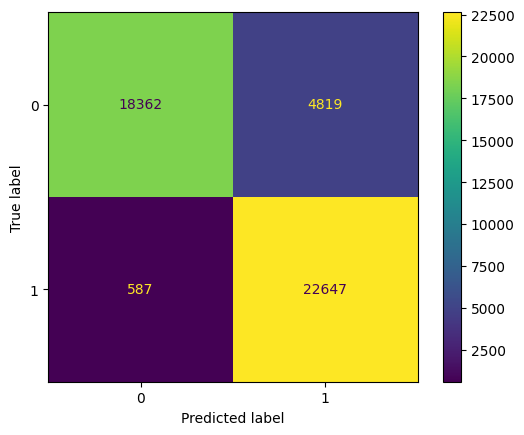

In [ ]:
import matplotlib.pyplot as plt
disp = ConfusionMatrixDisplay(confusion_matrix= cm)
disp.plot()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print('TRAINING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(y_train, text_clf.predict(x_train), target_names = categories))

print('\n \nTESTING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(y_test, text_clf.predict(x_test), target_names = categories))

TRAINING DATA CLASSIFICATION REPORT 
 

              precision    recall  f1-score   support

     suicide       0.97      0.81      0.89     92856
 non-suicide       0.84      0.98      0.90     92803

    accuracy                           0.89    185659
   macro avg       0.91      0.89      0.89    185659
weighted avg       0.91      0.89      0.89    185659


 
TESTING DATA CLASSIFICATION REPORT 
 

              precision    recall  f1-score   support

     suicide       0.97      0.79      0.87     23181
 non-suicide       0.82      0.97      0.89     23234

    accuracy                           0.88     46415
   macro avg       0.90      0.88      0.88     46415
weighted avg       0.90      0.88      0.88     46415



In [ ]:
import pickle
pickle.dump(text_clf, open("NaiveBayes.pkl", "wb"))

# **Support vector machine**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/suicide/Suicide_Detection.csv')

In [ ]:
categories = data["class"].unique()
x = data["text"].values
y = data["class"].values

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

In [ ]:
count_vect = CountVectorizer(stop_words = 'english')
x_train_counts = count_vect.fit_transform(x_train)

In [ ]:
tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

In [ ]:
from sklearn.svm import LinearSVC
clf = LinearSVC().fit(x_train_tfidf, y_train)

In [ ]:
x_test_counts = count_vect.transform(x_test)
x_new_tfidf = tfidf_transformer.transform(x_test_counts)

In [ ]:
predicted = clf.predict(x_new_tfidf)
predicted

array(['suicide', 'non-suicide', 'non-suicide', ..., 'suicide', 'suicide',
       'non-suicide'], dtype=object)

In [ ]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC()),
])
# Fitting our train data to the pipeline
text_clf.fit(x_train, y_train)

# Predicting our test data
predicted = text_clf.predict(x_test)
print('We got an accuracy of',np.mean(predicted == y_test)*100, '% over the test data.')

We got an accuracy of 94.16783367445869 % over the test data.


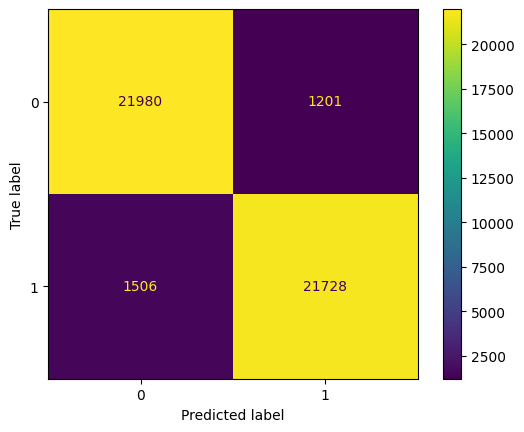

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm= confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix= cm)
disp.plot()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print('TRAINING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(y_train, text_clf.predict(x_train), target_names = categories))

print('\n \nTESTING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(y_test, text_clf.predict(x_test), target_names = categories))

TRAINING DATA CLASSIFICATION REPORT 
 

              precision    recall  f1-score   support

     suicide       0.98      0.97      0.97     92856
 non-suicide       0.97      0.98      0.97     92803

    accuracy                           0.97    185659
   macro avg       0.97      0.97      0.97    185659
weighted avg       0.97      0.97      0.97    185659


 
TESTING DATA CLASSIFICATION REPORT 
 

              precision    recall  f1-score   support

     suicide       0.94      0.95      0.94     23181
 non-suicide       0.95      0.94      0.94     23234

    accuracy                           0.94     46415
   macro avg       0.94      0.94      0.94     46415
weighted avg       0.94      0.94      0.94     46415



In [ ]:
import pickle
pickle.dump(text_clf, open("SupportVector.pkl", "wb"))

In [ ]:
model = pickle.load(open("/content/NaiveBayes.pkl", "rb"))